# Prueba técnica Bnext

* autor: Alberto García Cobo
* email: garcia.cobo.alberto@gmail.com

In [1]:
# https://bnext2.typeform.com/to/K2JiqU
# bnex test https://drive.google.com/drive/folders/1BfKrBxhJpPs1Jzfj9DVrLtif2V_Nj-Sd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def extract(path): 
    return pd.read_csv(path)

def transform(df): 
    # date
    df['date'] = pd.to_datetime(df.date)    
    return df

df = extract('./input/data_exports_data_test_181212.csv')
df = transform(df)
df.head()

,user_id,amount,category,date
0,jcbvas-raczml-ghjpyi,7.500,Purchase,2018-12-01 07:58:39
1,nscvb-jlazc-kihpj,0.000,Purchase,2018-12-01 07:58:27
2,aavoq-mmzuy-yypqt,125.000,Topup TPV,2018-12-01 07:57:50
3,jjiiav-rrggmz-ggxxyp,845.000,Purchase,2018-12-01 07:57:46
4,nqsoc-jylua-ktiqh,1009.925,Topup TPV,2018-12-01 07:57:16


## PREGUNTA 1: 
La primera pregunta tiene que ver con los usuarios que han gastado en este periodo. ¿Se te ocurre alguna manera de agrupar a los usuarios en función de su valor? Explica por favor la razón de agruparlos de la manera elegida y los cálculos que has realizado para ello.

### 1. Aproximación clásica

Los agrupo en función de si gastan más de lo que ingresan ya que Bnex puede usar esta información para ofrecer préstamos.

Para ello agrupo cada una de las operaciones por usuario y calculo el total. Si gasta más de lo que ingresa se pone balance_pos en **False**, o **True** si el balance sale positivo.


In [3]:

def balance(df): 
    pivot = pd.pivot_table(df, values='amount', index=['user_id'], columns=['category'], aggfunc=np.sum).fillna(0)
    pivot['balance'] = pivot['Topup TPV'] - pivot['Purchase'] - pivot['Bnext Send Money']
    pivot['balance_pos'] = np.where(pivot['balance'] > 0, True, False)
    return pivot

def remove_outliers(df_in, col_name):
    VALUE = 1.5
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    fence_low  = q1 - VALUE*iqr
    fence_high = q3 + VALUE*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


pivot = balance(df)
pivot.head(10)

category,Bnext Send Money,Purchase,Topup TPV,balance,balance_pos
user_id,,,,,
aaaas-mmmml-yyyyi,0.0,24.950,0.0,-24.950,False
aaabb-mmmcc-yyyjj,0.0,5.000,0.0,-5.000,False
aaaca-mmmam-yyyhy,0.0,350.600,400.0,49.400,True
aaaci-mmmag-yyyhx,0.0,102.450,0.0,-102.450,False
aaacn-mmmaj-yyyhk,0.0,1174.125,1375.0,200.875,True
aaaco-mmmau-yyyhq,0.0,124.425,750.0,625.575,True
aaacs-mmmal-yyyhi,0.0,142.125,77.5,-64.625,False
aaaia-mmmgm-yyyxy,0.0,23.900,125.0,101.100,True
aaaii-mmmgg-yyyxx,0.0,106.250,0.0,-106.250,False


SOLUCIÓN: Agrupamos los usuarios en función de su balance en el periodo de tiempo. Si es positivo o negativo para ofrecerles diferentes productos. 

### 2. Aproximación de Machine Learning
Otra forma de clasificar es mediante algún algoritmo de Machine Learning no supervisado En este caso he decidido usar **Kmeans**. De entre las opciones que he probado con la variable n_clusters, he decidido elegir n_clusters=3 ya que la diferenciación es más clara que con las demás.

Otros algoritmos posibles hubieran sido KNN y LDA (Latent Discriminant Analysis)

In [4]:
# imports
from sklearn.cluster import KMeans

# remove outliers de la columna amount para que la representación sea más visible
df_wo_outliers = remove_outliers(df, 'amount')
pivot = balance(df_wo_outliers)

# Elegimos las 3 dimensiones con valores numéricos económicos. 
df3d = pivot[['Bnext Send Money', 'Purchase', 'Topup TPV']]
X = np.array(df3d)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_pred = kmeans.labels_

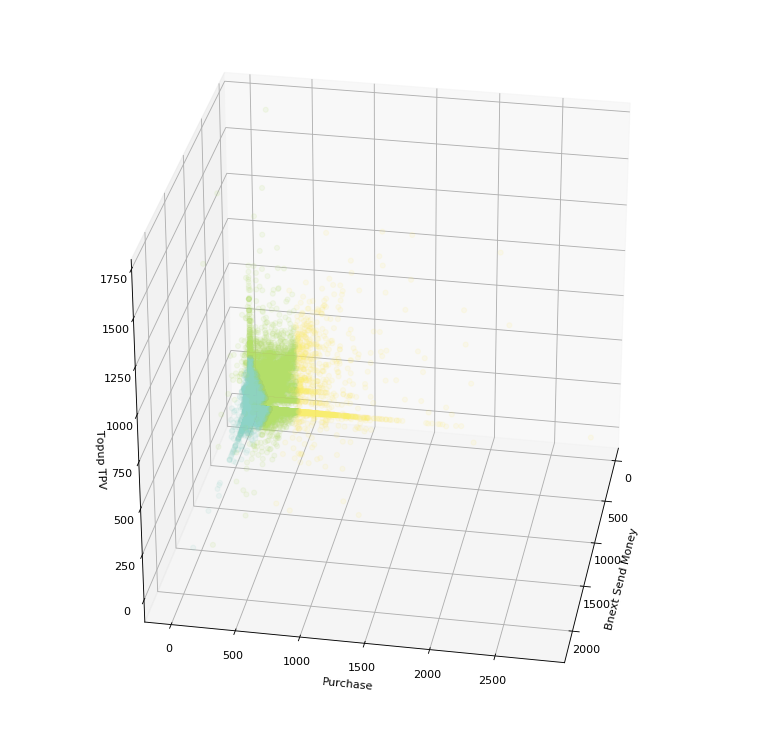

In [5]:
# gráfica 3d
from mpl_toolkits.mplot3d import Axes3D

def display_3d_scatter(X, df3d): 
    fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 10)
    ax.set_xlabel(df3d.columns[0])
    ax.set_ylabel(df3d.columns[1])
    ax.set_zlabel(df3d.columns[2])
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred, alpha=0.1, cmap="Set3"); 
    
display_3d_scatter(X, df3d)

In [6]:
# asignamos el label resultado de Kmeans a cada usuario
pivot['label'] = kmeans.labels_
pivot.groupby('label').max()

category,Bnext Send Money,Purchase,Topup TPV,balance,balance_pos
label,,,,,
0,1718.700,154.500,287.5,287.50,True
1,1666.275,394.625,1675.0,1508.65,True
2,2181.250,2822.650,1062.5,384.15,True



Se puede comprobar con la tabla anterior que el grupo 0 es el de más a la izquierda, el 1 el 
de enmedio y el 2 el más de la derecha. 

* cluster 0 es el que menos gasta
* cluster 1 el intermedio
* cluster 2 el que más. 

Por ello renombraremos los label por algo más entendible por los humanos


In [7]:
# renombramos
diccionario = {
    0: 'normal', 
    1: 'prefered', 
    2: 'VIP'
}
pivot.label = pivot.label.replace(diccionario)
pivot.head(10)

category,Bnext Send Money,Purchase,Topup TPV,balance,balance_pos,label
user_id,,,,,,
aaaas-mmmml-yyyyi,0.0,24.950,0.0,-24.950,False,normal
aaabb-mmmcc-yyyjj,0.0,5.000,0.0,-5.000,False,normal
aaaca-mmmam-yyyhy,0.0,350.600,400.0,49.400,True,prefered
aaaci-mmmag-yyyhx,0.0,102.450,0.0,-102.450,False,normal
aaacn-mmmaj-yyyhk,0.0,205.125,0.0,-205.125,False,prefered
aaaco-mmmau-yyyhq,0.0,124.425,0.0,-124.425,False,normal
aaacs-mmmal-yyyhi,0.0,142.125,77.5,-64.625,False,prefered
aaaia-mmmgm-yyyxy,0.0,23.900,125.0,101.100,True,normal
aaaii-mmmgg-yyyxx,0.0,106.250,0.0,-106.250,False,normal


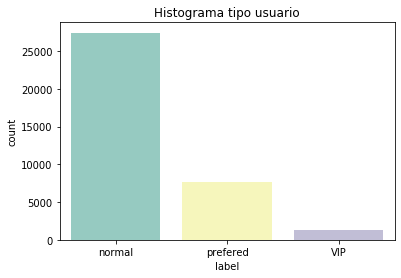

In [8]:
ax = sns.countplot(x="label", data=pivot, palette="Set3").set_title("Histograma tipo usuario")

SOLUCIÓN: Se han categorizado los usuarios en función del uso de la aplicación que tienen.

## PREGUNTA 2: 
Te pregunta el CEO que no entiende la evolución de los datos en el periodo escogido, que le parece algo anómala. ¿Encuentras algún patrón que permita encontrar outliers? Esta es una pregunta abierta, puedes analizar los datos de la manera que quieras. 

In [9]:
# tratamiento previo
df.date.max(), df.date.min()

(Timestamp('2018-12-01 07:58:39'), Timestamp('2018-11-20 07:59:18'))

In [10]:
# quitamos el último día y el primero xq no están enteras sus 24h y nos puede enturbiar los resultados 
df_time = df[(df['date'].dt.day != 1) & (df['date'].dt.day != 20)].copy()
df_time.date.max(), df_time.date.min()

(Timestamp('2018-11-30 23:59:49'), Timestamp('2018-11-21 00:00:28'))

In [11]:
# boxplot con iqr
import seaborn as sns
sns.set(style="darkgrid")

In [12]:
df_time['day_of_month'] = df_time.date.apply(lambda x: x.day)

# el día 1 diciembre lo colocamos
# df_time['day_of_month'] = np.where(df_time['day_of_month']==1, 31, df_time['day_of_month'])
df_time.head()

,user_id,amount,category,date,day_of_month
1384,svajq-lzmry-ipygt,22.050,Purchase,2018-11-30 23:59:49,30
1385,jcivcq-ragzay-ghxpht,36.025,Purchase,2018-11-30 23:59:33,30
1386,jivaqb-rgzmyc-gxpytj,625.000,Topup TPV,2018-11-30 23:59:28,30
1387,vvscv-zzlaz-ppihp,67.500,Topup TPV,2018-11-30 23:59:28,30
1388,jcvoa-razum-ghpqy,7.750,Purchase,2018-11-30 23:59:24,30


In [13]:
df_sum = df_time.groupby(['day_of_month', 'category']).sum()
df_sum.reset_index(inplace=True)

df_sum.head()

,day_of_month,category,amount
0,21,Bnext Send Money,141931.050
1,21,Purchase,367355.200
2,21,Topup TPV,787869.775
3,22,Bnext Send Money,252498.975
4,22,Purchase,445351.925


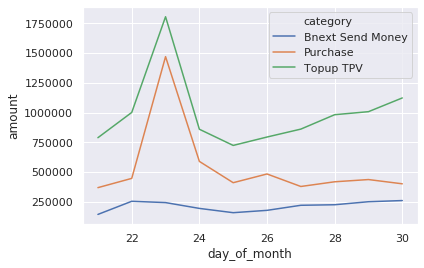

In [14]:
sns.lineplot(x="day_of_month", y="amount",
             hue="category", 
             data=df_sum)

In [15]:
# remove outliers
df_day_wo_outliers = remove_outliers(df_time, 'amount')

df_sum2 = df_day_wo_outliers.groupby(['day_of_month', 'category']).sum()
df_sum2.reset_index(inplace=True)

df_sum2.head()

,day_of_month,category,amount
0,21,Bnext Send Money,37258.025
1,21,Purchase,174434.500
2,21,Topup TPV,160421.850
3,22,Bnext Send Money,81170.475
4,22,Purchase,236907.625


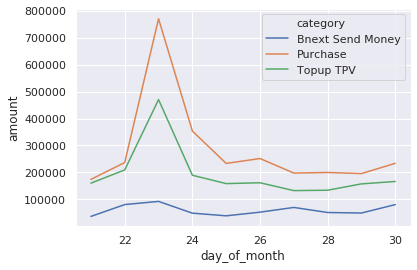

In [16]:
sns.lineplot(x="day_of_month", y="amount",
             hue="category", 
             data=df_sum2)


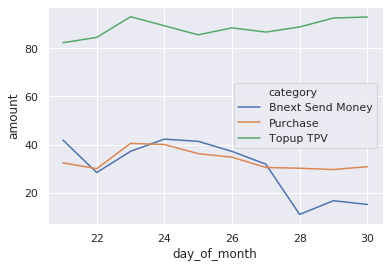

In [17]:
# ahora agrupamos por la media en vez de la suma y sin outliers

# remove outliers
df_day_wo_outliers = remove_outliers(df_time, 'amount')

df_mean = df_day_wo_outliers.groupby(['day_of_month', 'category']).mean()
df_mean.reset_index(inplace=True)

df_mean.head()

sns.lineplot(x="day_of_month", y="amount",
             hue="category", 
             data=df_mean)

El pico del 23 de Noviembre es el **Black Friday**. 

No ocurren compras más grandes sino que más compras de las mismas cantidades. 

Estudiando según la **media** entre los últimos 10 días del mes no hay una diferencia apreciable. 

## PREGUNTA 3 (opcional): 
Busca el concepto de cohorte si no estás familiarizadx con él, y realiza un análisis de cohortes diarias. Puedes considerar que la primera transacción de cada usuario en la muestra fue su primera transacción en Bnext. 

INTRO: 
Analizaremos dos grupos de entre los que han consumido durante el Black Friday. 
* el grupo A han gastado más de la media diaria (excluyendo el día en cuestión) en el black friday 
* el grupo B será el resto de usuarios

In [18]:
# media de purchase diario de los usuarios excluyendo el 23 Noviembre. 

df['day_of_month'] = df.date.apply(lambda x: x.day)
df.head(10)
df_wo_bf = df[(df['category']=="Purchase") \
              & (df['day_of_month']!=1) \
              & (df['day_of_month']!=20) \
              & (df['day_of_month']!=23)].groupby(['day_of_month']).mean()
mean_wo_bf = float(df_wo_bf.mean())
mean_wo_bf

59.63629768061229

In [19]:
# usuarios que han gastado más de esta media en el BF
users_bf = df[df['day_of_month']==23].groupby(['user_id']).sum()
top_purchasers = set(users_bf[users_bf['amount'] > mean_wo_bf].index)


In [20]:
# el resto de usuarios son
bottom_purchasers = set(df.user_id).difference(set(top_purchasers))

In [21]:
len(top_purchasers), len(bottom_purchasers), len(df.user_id.unique())

df_a = df_time[df_time['user_id'].isin(top_purchasers)]
df_b = df_time[df_time['user_id'].isin(bottom_purchasers)]

In [22]:
df_a.describe()

,amount,day_of_month
count,59474.000000,59474.000000
mean,136.315663,24.749521
std,328.328994,2.642879
min,0.000000,21.000000
25%,8.100000,23.000000
50%,49.975000,23.000000
75%,123.106250,27.000000
max,22500.000000,30.000000


In [23]:
df_b.describe()

,amount,day_of_month
count,88367.000000,88367.000000
mean,105.659577,25.803275
std,254.634958,2.944077
min,0.000000,21.000000
25%,7.500000,23.000000
50%,26.500000,26.000000
75%,74.600000,28.000000
max,14870.000000,30.000000


A simple vista los valores de conjunto de los usuarios que compraron en el BF por encima de su media 


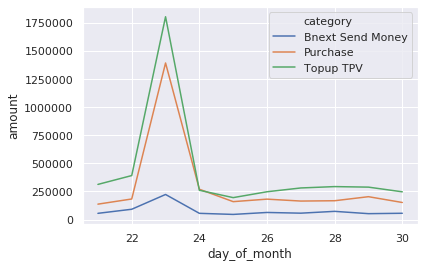

In [24]:
df_a

df_sum_a = df_a.groupby(['day_of_month', 'category']).sum()
df_sum_a.reset_index(inplace=True)

sns.lineplot(x="day_of_month", y="amount",
             hue="category", 
             data=df_sum_a)



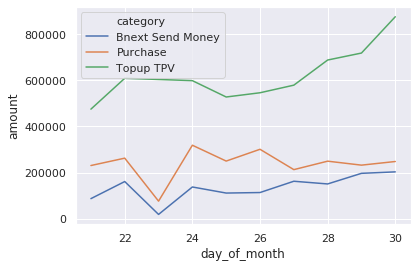

In [25]:
df_b

df_sum_b = df_b.groupby(['day_of_month', 'category']).sum()
df_sum_b.reset_index(inplace=True)

sns.lineplot(x="day_of_month", y="amount",
             hue="category", 
             data=df_sum_b)

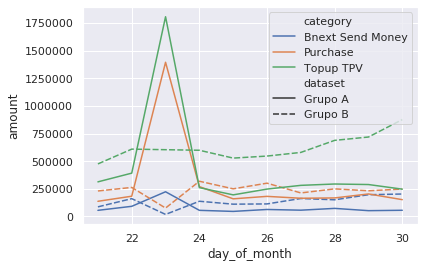

In [26]:
# Ahora unimos ambos gráficos para compararlos

concatenated = pd.concat([df_sum_a.assign(dataset='Grupo A'), df_sum_b.assign(dataset='Grupo B')])
sns.lineplot(x='day_of_month', y='amount', data=concatenated,
                hue='category', style='dataset')


Se puede observar que el grupo B, el que no gastó más de la media en el Black Friday, tiende a ingresar en al aplicación más dinero que el otro grupo, que ingresa y gasta el mismo día 23. 